In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
#설치 시 pip install scikit-learn 으로 설치
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:

df = pd.read_csv('data_process_result/re_fixed_multivariate_timeseires.csv')
df.drop(df.loc[df['datetime'].duplicated()].index, inplace = True)
df['datetime'] = pd.to_datetime(df['datetime'])

# df = df.sort_values(df['datetime'], ascending=[True])


df.set_index(df['datetime'], inplace = True)
df.drop(columns = [ 'datetime'], inplace = True)

In [3]:
steps=24
dataset_for_prediction= df.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['GBP/mWh'].shift(-steps)   # 가격 예측이기 때문에 실제값이라는 걸 표시
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction


,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price,Actual
datetime,,,,,,,
2013-01-03 00:00:00,34.06,50.70,95.27,112.14,43.0,3.198,39.96
2013-01-03 01:00:00,30.54,50.44,95.27,112.14,43.0,3.198,34.92
2013-01-03 02:00:00,28.85,50.35,95.27,112.14,43.0,3.198,31.88
2013-01-03 03:00:00,27.67,50.39,95.27,112.14,43.0,3.198,29.98
2013-01-03 04:00:00,26.52,50.36,95.27,112.14,43.0,3.198,29.30
...,...,...,...,...,...,...,...
2019-12-30 18:00:00,54.00,45.24,70.68,68.16,25.0,2.158,45.60
2019-12-30 19:00:00,46.95,44.23,70.68,68.16,25.0,2.158,39.07
2019-12-30 20:00:00,39.40,43.67,70.68,68.16,25.0,2.158,37.71


### Scaling inputs and outpust seperately

In [4]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['GBP/mWh', 'temperature','coal Price','oil Price', 'uranium Price','natural gas Price','Actual']])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [5]:
list( dataset_for_prediction.columns)

['GBP/mWh',
 'temperature',
 'coal Price',
 'oil Price',
 'uranium Price',
 'natural gas Price',
 'Actual']

In [6]:
X.rename(columns = {0:'GBP/mWh',
 1:'temperature',
 2:'coal Price',
 3:'oil Price',
 4:'uranium Price',
 5:'natural gas Price',
 6:'Actual'}, inplace = True)

In [7]:
X.index = dataset_for_prediction.index
X.drop(columns = 'Actual', inplace = True)

y.rename(columns={0:'Electricity price in 24 hours'}, inplace= True)
y.index=dataset_for_prediction.index

In [8]:
X[24:52359]

,GBP/mWh,temperature,coal Price,oil Price,uranium Price,natural gas Price
datetime,,,,,,
2013-01-04 00:00:00,0.042721,0.381875,0.778183,0.916612,0.961905,0.365410
2013-01-04 01:00:00,0.037691,0.376323,0.778183,0.916612,0.961905,0.365410
2013-01-04 02:00:00,0.034656,0.365608,0.778183,0.916612,0.961905,0.365410
2013-01-04 03:00:00,0.032760,0.357862,0.778183,0.916612,0.961905,0.365410
2013-01-04 04:00:00,0.032081,0.356958,0.778183,0.916612,0.961905,0.365410
...,...,...,...,...,...,...
2018-12-31 19:00:00,0.056536,0.341208,0.820160,0.267194,0.417143,0.368958
2018-12-31 20:00:00,0.054540,0.340434,0.820160,0.267194,0.417143,0.368958
2018-12-31 21:00:00,0.050068,0.342370,0.820160,0.267194,0.417143,0.368958


In [9]:
train_X, train_y = X[24:52359], y[24:52359]  #학습을 위한 데이터 분리
test_X, test_y = X[52359:].dropna(), y[52359:].dropna()  #테스트 데이터

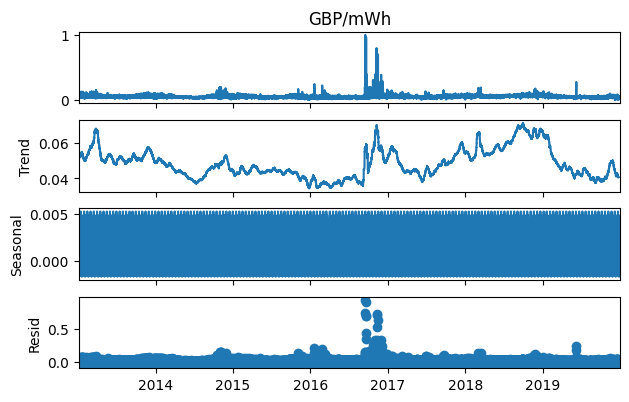

In [10]:
seas_d=sm.tsa.seasonal_decompose(X['GBP/mWh'],model='addtive',period=365)
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout['critical value {}'.format(key)]=val
    if dftest[1]<=0.05:  #바람직함
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)
        
y_test=y['Electricity price in 24 hours'][24:52359].dropna()
test_adf(y_test, " Electricity Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary  Electricity Price


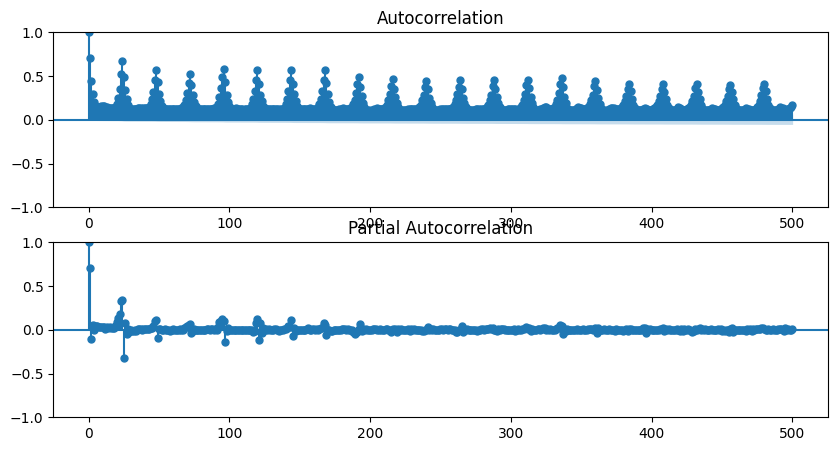

In [12]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=500, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=500, ax=ax[1])
plt.show()

In [13]:
#!sudo pip install pmdarima
from pmdarima.arima import auto_arima


In [14]:
step_wise = auto_arima(train_y, 
     exogenous= train_X,
     start_p=0, start_q=0, 
     max_p=5, max_q=5, 
     d=1, max_d=168,
     n_jobs = -1,
     start_Q=0,
     max_P=5,
     max_D=5,
     max_Q=5,
     seasonal = True,
     stationary = True,
     trace=True, 
     error_action='ignore', 
     suppress_warnings=True, 
     random = True,
     stepwise=False)


Best model:  ARIMA(1,0,4)(0,0,0)[1] intercept
Total fit time: 35.039 seconds


In [15]:
step_wise.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                52335
Model:               SARIMAX(1, 0, 4)   Log Likelihood              153767.498
Date:                Fri, 02 Jun 2023   AIC                        -307520.996
Time:                        11:21:15   BIC                        -307458.938
Sample:                             0   HQIC                       -307501.597
                              - 52335                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0117      0.000     24.709      0.000       0.011       0.013
ar.L1          0.7596      0.009     79.959      0.000       0.741       0.778
ma.L1          0.0243      0.010      2.535      0.011       0.006       0.043
ma.L2         -0.1352      0.007    -18.041      0.000      -0.150      -0.121
ma.L3         -0.0458      0.005     -9.048      0.000      -0.056      -0.036
ma.L4         -0.0420      0.004    -11.283      0.000      -0.049      -0.035
sigma2         0.0002   5.49e-08   2992.044      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):        3026025276.89
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            17.68
Prob(H) (two-sided):                  0.00   Kurtosis:                      1180.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
model= SARIMAX(train_y, 
 exog=train_X,
 order=(1,0,3),
enforce_invertibility=False, enforce_stationarity=False)

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
results=model.fit()

forecast = results.forecast(steps=len(test_X), exog = test_X)

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [18]:
type(forecast)

pandas.core.series.Series

In [19]:
train_size = len(train_X)
test_size = train_size+len(test_X)
steps = -24

In [20]:
predictions= results.predict(start = train_size, end=test_size-1 ,exog=test_X)

c:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
forecast_electricity= pd.DataFrame(forecast)
forecast_electricity.reset_index(drop=True, inplace=True)
forecast_electricity.index=test_X.index
forecast_electricity['Actual'] =scaler_output.iloc[52359:, 0]
forecast_electricity.rename(columns={'predicted_mean':'Forecast'}, inplace=True)

<Axes: xlabel='datetime'>

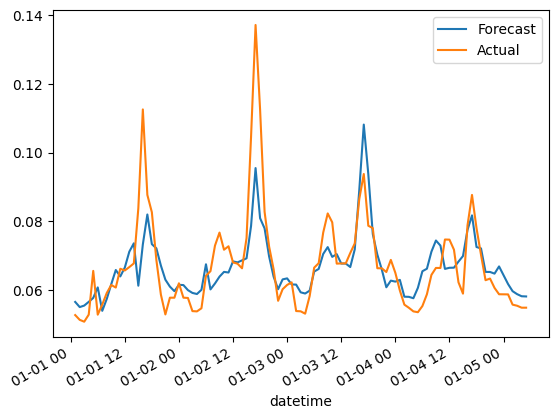

In [22]:
forecast_electricity['Forecast'][:100].plot(legend=True)
forecast_electricity['Actual'][:100].plot(legend=True)

In [23]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [24]:
mape = mean_absolute_percentage_error(forecast_electricity['Actual'], forecast_electricity['Forecast'])
mape

14.710827864968994

In [25]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])


In [26]:
act.head()

,Electricity price in 24 hours
datetime,
2018-12-30 00:00:00,0.058492
2018-12-31 01:00:00,0.048980
2018-12-31 02:00:00,0.046854
2018-12-31 03:00:00,0.047163
2018-12-31 04:00:00,0.048780


In [27]:

predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Electricity price in 24 hours']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [28]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [29]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])


unscaled = pd.DataFrame(testPredict)
unscaled['actual'] = testActual
unscaled = unscaled.rename(columns={0: 'predictions'})

<Axes: >

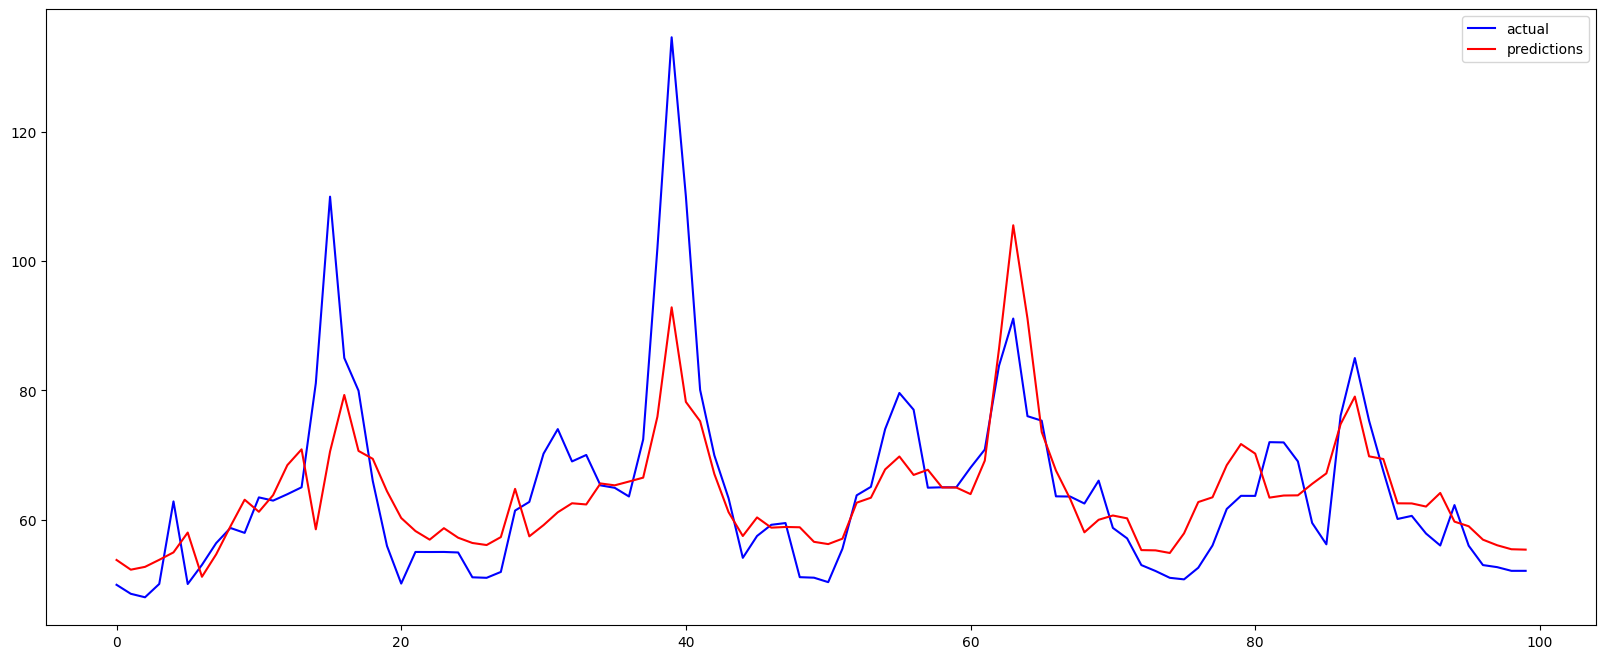

In [30]:
unscaled['actual'][:100].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][:100].plot(legend=True, color='red', figsize=(20,8))

<Axes: >

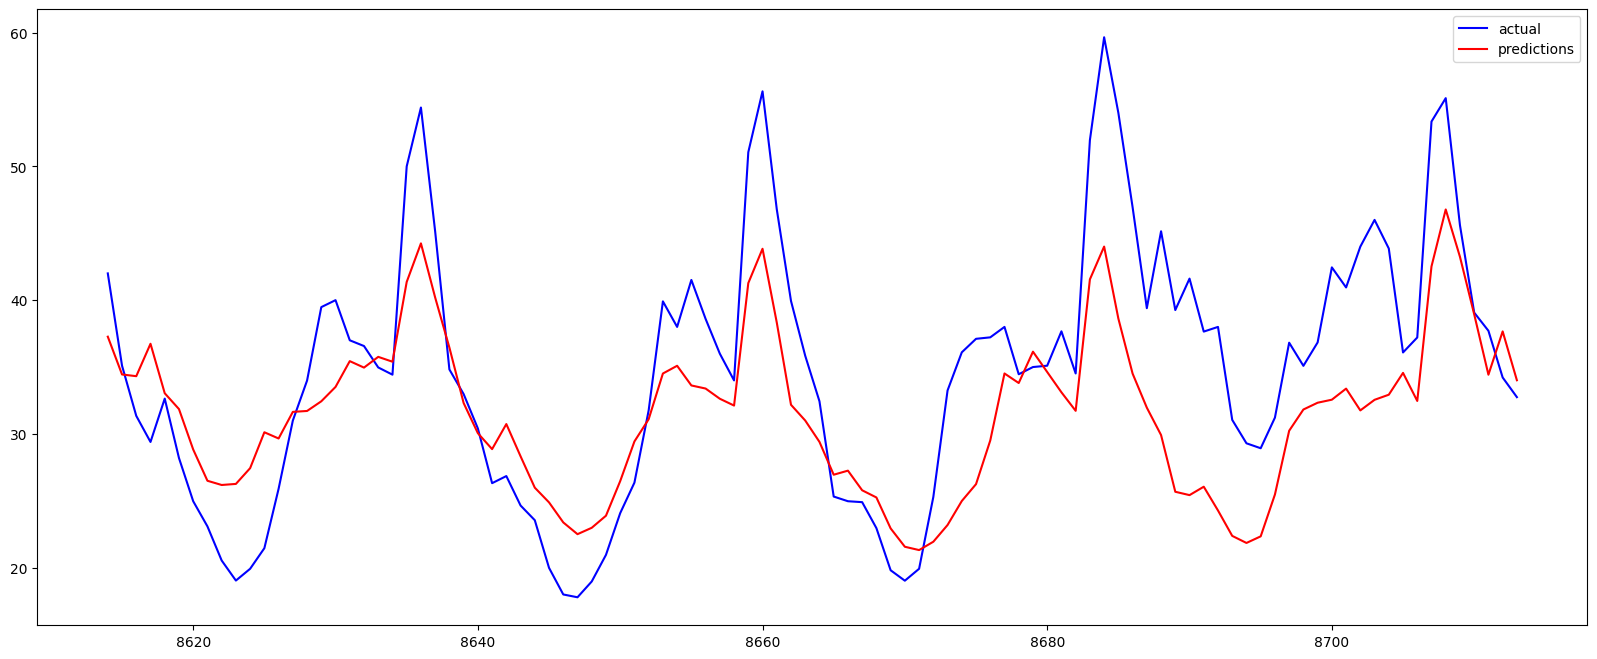

In [31]:
unscaled['actual'][-100:].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][-100:].plot(legend=True, color='red', figsize=(20,8))

In [32]:
#!sudo pip install xgboost

In [33]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [34]:
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[11:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:24:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

0.2320898495954693
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'n_jobs': -1, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [35]:
xgbbest = xgb.XGBRegressor(min_child_weight = 4, max_depth = 6, n_estimators = 100, learning_rate=0.05, colsample_bytree =0.7, n_jobs = -1, silent = 1 , subsample = 0.7)
xgbbest.fit(train_X,
         train_y)

[11:24:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
predictionsxgb = xgbbest.predict(test_X)

In [37]:
predictionsxgb=pd.DataFrame(predictionsxgb)
predictionsxgb.reset_index(drop=True, inplace=True)
predictionsxgb.index=test_X.index
predictionsxgb['Actual'] = act['Electricity price in 24 hours']
predictionsxgb.rename(columns={0:'Pred'}, inplace=True)


In [38]:
testPredictxgb = sc_out.inverse_transform(predictions[['Pred']])
testActualxgb = sc_out.inverse_transform(predictions[['Actual']])

unscaledxgb = pd.DataFrame(testPredictxgb)
unscaledxgb['actual'] = testActualxgb
unscaledxgb = unscaledxgb.rename(columns={0: 'predictions'})



<Axes: >

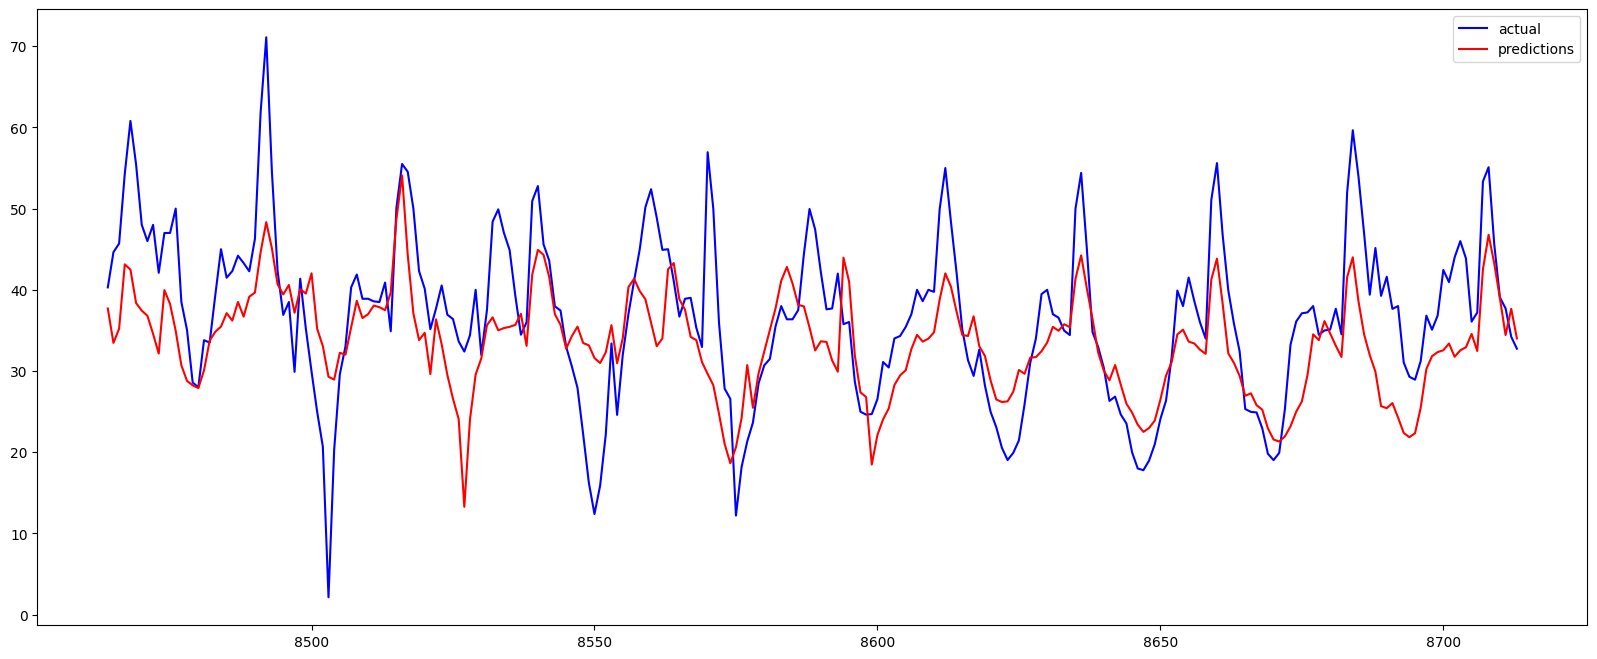

In [39]:
unscaledxgb['actual'][-250:].plot(figsize=(20,8), legend=True, color='blue')
unscaledxgb['predictions'][-250:].plot(legend=True, color='red', figsize=(20,8))

In [40]:
mape = mean_absolute_percentage_error(unscaledxgb['actual'], unscaledxgb['predictions'])
mape

147.62765111447212